# Section11 ハイパーパラメータチューニング

## Grid Search

Grid Search
- sklearn.model_selction.GridSearchCVクラス
    1. インスタンス生成
        - estimator: sklearnのモデルインスタンス
        - param_grid: 探索するパラメータと値のdictionary{"name" : [value,..],...}
        - scoring: 評価指標
        - cv: sklearnのCVオブジェクト
    2. .fit(X,y)で学習
        - fit_paramsにestimatorのfitメソッドの引数を渡すことが可能
    3. .best_params_や、.best_score_で結果を確認

In [1]:
# データセットの抽出
from sklearn.datasets import fetch_california_housing
dataset = fetch_california_housing()

print(dataset['DESCR'])

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [2]:
import pandas as pd

In [3]:
# データ準備
X = pd.DataFrame(dataset['data'], columns=dataset['feature_names'])
y = dataset['target']

# hold-out
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

# モデル
import lightgbm as lgb
lgbmr = lgb.LGBMRegressor(random_state=0)
param_grid = {'num_leaves': [10, 20, 30, 40, 50, 60],
              'max_depth': [5, 10, 15], 
              'reg_alpha': [0, 0.01, 0.03]}

from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
cv = KFold(n_splits=3, random_state=0, shuffle=True)
gs = GridSearchCV(lgbmr, param_grid=param_grid, cv=cv)

In [4]:
# early_stopping
callbacks = [lgb.early_stopping(stopping_rounds=10)]
eval_set = [(X_val, y_val)]
fit_params = {'callbacks': callbacks, 'eval_set': eval_set}
gs.fit(X_train, y_train, **fit_params)

Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.264841
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.256456
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.256456
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.256456
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.256456
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.256456
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.256456
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.255538
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.255538
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.240402
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.240164
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.240164
Did not meet ea

GridSearchCV(cv=KFold(n_splits=3, random_state=0, shuffle=True),
             estimator=LGBMRegressor(random_state=0),
             param_grid={'max_depth': [5, 10, 15],
                         'num_leaves': [10, 20, 30, 40, 50, 60],
                         'reg_alpha': [0, 0.01, 0.03]})

In [5]:
# GridSearchの結果をdfで確認する
# 'rank_test_score': 実施したパラメータが何番目に良かったか表す指標
cv_result_df = pd.DataFrame(gs.cv_results_)
cv_result_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_num_leaves,param_reg_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.081728,0.041417,0.007350,0.000433,5,10,0,"{'max_depth': 5, 'num_leaves': 10, 'reg_alpha'...",0.797096,0.807785,0.805461,0.803448,0.004590,54
1,0.050923,0.006553,0.005699,0.000260,5,10,0.01,"{'max_depth': 5, 'num_leaves': 10, 'reg_alpha'...",0.798894,0.806981,0.806050,0.803975,0.003613,53
2,0.067710,0.018897,0.008591,0.002288,5,10,0.03,"{'max_depth': 5, 'num_leaves': 10, 'reg_alpha'...",0.799277,0.806364,0.806658,0.804100,0.003413,52
3,0.065306,0.004163,0.006159,0.000172,5,20,0,"{'max_depth': 5, 'num_leaves': 20, 'reg_alpha'...",0.811435,0.821243,0.815893,0.816190,0.004010,36
4,0.068682,0.011591,0.006634,0.000357,5,20,0.01,"{'max_depth': 5, 'num_leaves': 20, 'reg_alpha'...",0.810028,0.821356,0.813901,0.815095,0.004701,45


In [6]:
# top5を表示
for _, row in cv_result_df[cv_result_df['rank_test_score']<=5].iterrows():
    print(f"{row['rank_test_score']}: {row['params']}")
    print(f"{row['mean_test_score']}")

4: {'max_depth': 10, 'num_leaves': 50, 'reg_alpha': 0.01}
0.8329725903236045
3: {'max_depth': 15, 'num_leaves': 50, 'reg_alpha': 0}
0.8331058990226472
2: {'max_depth': 15, 'num_leaves': 50, 'reg_alpha': 0.03}
0.8332059773155042
5: {'max_depth': 15, 'num_leaves': 60, 'reg_alpha': 0}
0.8327661059213919
1: {'max_depth': 15, 'num_leaves': 60, 'reg_alpha': 0.01}
0.8338051795879502


In [7]:
# 最も良いハイパーパラメータの組み合わせで再度学習し評価
lgbmr = lgb.LGBMRegressor(**gs.best_params_, random_state=0, learning_rate=0.01, n_estimators=1000)
callbacks = [lgb.early_stopping(stopping_rounds=10)]
eval_set = [(X_val, y_val)]
fit_params = {'callbacks': callbacks, 'eval_set': eval_set}
lgbmr.fit(X_train, y_train, **fit_params)

Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.195693


LGBMRegressor(learning_rate=0.01, max_depth=15, n_estimators=1000,
              num_leaves=60, random_state=0, reg_alpha=0.01)

In [8]:
lgbmr.score(X_val, y_val)

0.8499232425233268

## Pipeline + Grid Search

pipeline
- sklearn.pipeline.Pipeline
    - インスタンス生成し、modelオブジェクトやStandardScalerのように、.fitや.predictや.trannsoformメソッドを利用できる
    - staps引数に処理をリストで指定する
        - [('処理名1', クラス()), ('処理名2', クラス()),...]の形で記述する
        - それぞれのクラスは.fitなどのメソッドを持っている必要がある
    - pipelineオブジェクトをmodelオブジェクトのように使用できる
        - 例えばcross_val_score()にmodelの代わりにpipelineを入れる

pipeline+GridSearch

PipelineとGridSearchを組み合わせることで、前処理を含めてGridSearchが可能になりコードも綺麗になる

    1.pipeineオブジェクトの生成
        - 前処理やモデルのオブジェクトをSteps引数に渡す
        - 特定のカラムに処理する場合はColumnsTransformerを併用する
    2. cvオブジェクトを作成
    3. GridSearchCVオブジェクトを作成
        - estimator引数にはPipelineオブジェクトを渡す
        - param_grid引数には、pipelineで指定した名前を接頭辞に使用する
            - ex: {"pca__n__components [5,10]", "logistics__C":[1,5,10]}
    4. .best_params_や.best_score_, .cv_results_で結果確認

In [9]:
import numpy as np

df = pd.read_csv('penguins_size.csv')

# データクリーニング
df.loc[df[df['sex']=='.'].index[0], 'sex'] = np.nan
df.dropna(thresh=3, inplace=True)

X = df.drop('species', axis=1)
y = df['species']

In [10]:
# 欠損値代入、カテゴリカルカラムのエンコーディング
# 欠損値代入
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

cat_cols = X.select_dtypes(exclude=np.number).columns.to_list()
imputer = SimpleImputer(strategy='most_frequent')
ct = ColumnTransformer([('cat_imputer', imputer, cat_cols)], remainder='passthrough')  # defaultのremainder='drop'だと、cat_cols以外のカラムがdropされる
ct.set_output(transform='pandas')

# OHE(OneHotEncoding)
from sklearn.base import BaseEstimator, TransformerMixin
class GetDummies(BaseEstimator, TransformerMixin):
    """
    BaseEstimatorとTransformMininクラスを継承した
    ダミー変数のカラムを作るクラス
    """
    
    def __init__(self):
        self.columns = None
        
    def fit(self, X, y=None):
        self.columns = pd.get_dummies(X).columns
        return self
    
    def transform(self, X):
        X_new = pd.get_dummies(X)
        return X_new.reindex(columns=self.columns, fill_value=0)

    
# model
import lightgbm as lgb
lgbmc = lgb.LGBMClassifier(random_state=0)
    
# pipeline
from sklearn.pipeline import Pipeline
pipeline = Pipeline([('impute', ct), 
                     ('dummy', GetDummies()), 
                     ('model', lgbmc)])

# KFold
cv = KFold(n_splits=3, random_state=0, shuffle=True)

# grid srarch
# 
param_grid = {'model__num_leaves': [10, 20, 30, 40, 50, 60],
              'model__max_depth':  [5, 10, 15], 
              'model__reg_alpha':  [0, 0.01, 0.03]}
gs = GridSearchCV(pipeline, param_grid=param_grid, cv=cv)
gs.fit(X, y)

GridSearchCV(cv=KFold(n_splits=3, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('impute',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat_imputer',
                                                                         SimpleImputer(strategy='most_frequent'),
                                                                         ['island',
                                                                          'sex'])])),
                                       ('dummy', GetDummies()),
                                       ('model',
                                        LGBMClassifier(random_state=0))]),
             param_grid={'model__max_depth': [5, 10, 15],
                         'model__num_leaves': [10, 20, 30, 40, 50, 60],
                         'model__reg_alpha': [0, 0.01, 0.03]})

In [11]:
cv_results_df = pd.DataFrame(gs.cv_results_)
cv_results_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__max_depth,param_model__num_leaves,param_model__reg_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.060908,0.024078,0.009455,0.001128,5,10,0,"{'model__max_depth': 5, 'model__num_leaves': 1...",0.991228,0.982456,0.991228,0.988304,0.004135,1
1,0.032111,0.001260,0.008526,0.000990,5,10,0.01,"{'model__max_depth': 5, 'model__num_leaves': 1...",0.991228,0.991228,0.973684,0.985380,0.008270,19
2,0.028621,0.000976,0.007572,0.000134,5,10,0.03,"{'model__max_depth': 5, 'model__num_leaves': 1...",0.991228,0.991228,0.973684,0.985380,0.008270,19
3,0.044273,0.002174,0.008617,0.000473,5,20,0,"{'model__max_depth': 5, 'model__num_leaves': 2...",0.991228,0.982456,0.991228,0.988304,0.004135,1
4,0.035888,0.002305,0.008217,0.000278,5,20,0.01,"{'model__max_depth': 5, 'model__num_leaves': 2...",0.991228,0.991228,0.973684,0.985380,0.008270,19


## Random Search

Random Search
- sklearn.model_selection.RandomSearchCVクラス
    1. インスタンス生成
        - estimator: sklearnのモデルインスタンス
        - param_distributions: 探索するパラメータと値を出力するobject（または値のリスト）のdict
            - 例：　{"name": object}
            - objectは.rvs()メソッドを実装している必要がある
                - scipy.stats.uniformやscipy.stats.randinetを使用することが多い
        - scoring: 評価指標
        - cv: sklearnのcvオブジェクト
        - n_iter: イテレーション数
    2. .fit（X,y）で学習
    3. _best_params_や.best_score_で結果を確認

In [12]:
# データ準備
dataset = fetch_california_housing()
X = pd.DataFrame(dataset['data'], columns=dataset['feature_names'])
y = dataset['target']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

# モデル
lgbmc = lgb.LGBMRegressor(random_state=0)
# random search
from scipy.stats import uniform, randint
param_dist = {'num_leaves': randint(10, 60),
              'max_depth':  randint(5, 15), 
              'reg_alpha':  uniform(0, 0.03)}
# cf: gred search
# param_grid = {'num_leaves': [10, 20, 30, 40, 50, 60],
#               'max_depth': [5, 10, 15], 
#               'reg_alpha': [0, 0.01, 0.03]}

# early stopping
eval_set = [(X_val, y_val)]
callbacks = [lgb.early_stopping(stopping_rounds=10)]
fit_params = {'callbacks': callbacks, 'eval_set': eval_set}

# cv
from sklearn.model_selection import KFold
cv = KFold(n_splits=3, shuffle=True, random_state=0)

# random search
from sklearn.model_selection import RandomizedSearchCV
rs = RandomizedSearchCV(lgbmr, param_distributions=param_dist, cv=cv, n_iter=36)
rs.fit(X_train, y_train, **fit_params)

Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.23945
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.231029
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.231029
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.221184
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.219495
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.219495
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.212796
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.207817
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.207817
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.207817
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.207428
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.207428
Did not 

RandomizedSearchCV(cv=KFold(n_splits=3, random_state=0, shuffle=True),
                   estimator=LGBMRegressor(learning_rate=0.01, max_depth=15,
                                           n_estimators=1000, num_leaves=60,
                                           random_state=0, reg_alpha=0.01),
                   n_iter=36,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f3edad09ac0>,
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f3ed183b310>,
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f3edad015e0>})

In [13]:
cv_results_df = pd.DataFrame(rs.cv_results_)
cv_results_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_num_leaves,param_reg_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,2.045858,0.719973,0.108042,0.004640,5,30,0.019602,"{'max_depth': 5, 'num_leaves': 30, 'reg_alpha'...",0.811268,0.822737,0.815025,0.816343,0.004774,34
1,1.710818,0.082641,0.116353,0.006143,14,28,0.014029,"{'max_depth': 14, 'num_leaves': 28, 'reg_alpha...",0.825989,0.831962,0.826552,0.828168,0.002693,20
2,3.700408,0.282902,0.164409,0.003618,12,52,0.012602,"{'max_depth': 12, 'num_leaves': 52, 'reg_alpha...",0.832436,0.839196,0.831926,0.834520,0.003314,1
3,2.648088,0.298901,0.201329,0.051404,11,51,0.000129,"{'max_depth': 11, 'num_leaves': 51, 'reg_alpha...",0.830996,0.838578,0.831587,0.833720,0.003443,4
4,2.529855,0.488306,0.136949,0.006652,12,41,0.014568,"{'max_depth': 12, 'num_leaves': 41, 'reg_alpha...",0.830305,0.837982,0.830720,0.833002,0.003525,7


In [14]:
for _, row in cv_result_df[cv_result_df['rank_test_score']<=5].iterrows():
    print(f"{row['rank_test_score']}: {row['params']}")
    print(f"{row['mean_test_score']}")

4: {'max_depth': 10, 'num_leaves': 50, 'reg_alpha': 0.01}
0.8329725903236045
3: {'max_depth': 15, 'num_leaves': 50, 'reg_alpha': 0}
0.8331058990226472
2: {'max_depth': 15, 'num_leaves': 50, 'reg_alpha': 0.03}
0.8332059773155042
5: {'max_depth': 15, 'num_leaves': 60, 'reg_alpha': 0}
0.8327661059213919
1: {'max_depth': 15, 'num_leaves': 60, 'reg_alpha': 0.01}
0.8338051795879502


In [15]:
rs.best_params_

{'max_depth': 12, 'num_leaves': 52, 'reg_alpha': 0.012601650810659159}

In [16]:
from scipy.stats import uniform, randint

In [17]:
# 0~1の値をランダムにとってくる
uniform(0, 1).rvs()

0.15421152482055223

In [18]:
# 10〜50の整数値をランダムにとってくる
randint(10, 50).rvs()

37

## ベイズ最適化

ベイズ最適化
- hyperoptライブラリ
    - pip install hyperoptでインストール
    - hyperopt.fmin()
        - objective: 最小化したい目的関数(pythonの関数)を渡す
            - モデルのインスタンス生成
            - 学習および評価
            - 精度を返す
        - space: 変数の範囲をdirectory形式で渡す
            - hyperopt.hp.quniform()やhyperopt.uniform()を使用
        - algo: tpe.suggest
        - max_eval: イテレーション数

In [19]:
from hyperopt import hp, tpe
from hyperopt.fmin import fmin

In [30]:
# データ準備
dataset = fetch_california_housing()
X = pd.DataFrame(dataset['data'], columns=dataset['feature_names'])
y = dataset['target']

In [34]:
# 関数
def objective(params):
    
    # paramsに入っている値は全てfloatなので，intにcastする
    params = {'num_leaves': int(params['num_leaves']),
              'max_depth':  int(params['max_depth']),
              'reg_alpha':  params['reg_alpha']}
    
    model = lgb.LGBMRegressor(**params, random_state=0)
    cv = KFold(n_splits=3, shuffle=True, random_state=0)
    scores = cross_val_score(model, X, y, cv=cv)
    
    # hyperoptにはlogを取る仕組みがないため別途logを保存させる
    log['params'].append(params)
    log['score'].append(scores.mean())
    log['score_std'].append(scores.std())
    
    # 最小化をすることを目指すので，scoreは負の形にして低ければ精度が良いという形にする
    return -scores.mean()

# 変数の範囲
spaces = {'num_leaves': hp.quniform('num_leaves', 10, 60, 2),
          'max_depth':  hp.quniform('max_depth', 5, 15, 2), 
          'reg_alpha':  hp.uniform('reg_alpha', 0, 0.03)}

log = {'params': [], 'score': [], 'score_std': []}
best = fmin(fn=objective, space=spaces, algo=tpe.suggest, max_evals=100)

100%|██████████| 100/100 [00:54<00:00,  1.84trial/s, best loss: -0.8425267279008261]


In [37]:
log_df = pd.DataFrame(log)
log_df.sort_values(by='score', ascending=False)

,params,score,score_std
64,"{'num_leaves': 60, 'max_depth': 14, 'reg_alpha...",0.842527,0.003162
61,"{'num_leaves': 60, 'max_depth': 14, 'reg_alpha...",0.841968,0.003642
76,"{'num_leaves': 60, 'max_depth': 14, 'reg_alpha...",0.841944,0.003650
62,"{'num_leaves': 60, 'max_depth': 14, 'reg_alpha...",0.841312,0.002228
65,"{'num_leaves': 60, 'max_depth': 14, 'reg_alpha...",0.841225,0.003514
...,...,...,...
57,"{'num_leaves': 14, 'max_depth': 10, 'reg_alpha...",0.819117,0.002722
9,"{'num_leaves': 14, 'max_depth': 8, 'reg_alpha'...",0.818479,0.003849
88,"{'num_leaves': 12, 'max_depth': 14, 'reg_alpha...",0.813769,0.003681
45,"{'num_leaves': 10, 'max_depth': 14, 'reg_alpha...",0.809550,0.004626


In [38]:
log_df[['num_leaves', 'max_depth', 'reg_alpha']] = log_df.apply(lambda row: pd.Series(row['params']), axis=1)

In [40]:
log_df.sort_values(by='score', ascending=False)

,params,score,score_std,num_leaves,max_depth,reg_alpha
64,"{'num_leaves': 60, 'max_depth': 14, 'reg_alpha...",0.842527,0.003162,60.0,14.0,0.020388
61,"{'num_leaves': 60, 'max_depth': 14, 'reg_alpha...",0.841968,0.003642,60.0,14.0,0.020112
76,"{'num_leaves': 60, 'max_depth': 14, 'reg_alpha...",0.841944,0.003650,60.0,14.0,0.019995
62,"{'num_leaves': 60, 'max_depth': 14, 'reg_alpha...",0.841312,0.002228,60.0,14.0,0.008646
65,"{'num_leaves': 60, 'max_depth': 14, 'reg_alpha...",0.841225,0.003514,60.0,14.0,0.018377
...,...,...,...,...,...,...
57,"{'num_leaves': 14, 'max_depth': 10, 'reg_alpha...",0.819117,0.002722,14.0,10.0,0.014191
9,"{'num_leaves': 14, 'max_depth': 8, 'reg_alpha'...",0.818479,0.003849,14.0,8.0,0.000116
88,"{'num_leaves': 12, 'max_depth': 14, 'reg_alpha...",0.813769,0.003681,12.0,14.0,0.015320
45,"{'num_leaves': 10, 'max_depth': 14, 'reg_alpha...",0.809550,0.004626,10.0,14.0,0.019223


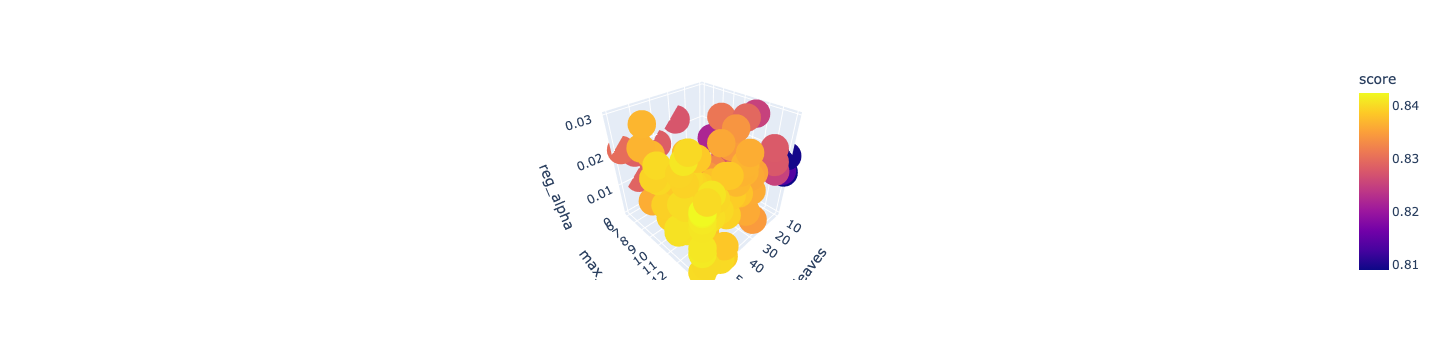

In [51]:
# 描画
# plotlyライブラリを使って、'num_leaves', 'max_depth', 'reg_alpha'を３次元で描画する
# ベイズ最適化を使うと、よりスコアが高い領域で分布が集中して、
import plotly.express as px
fig = px.scatter_3d(log_df, x='num_leaves', y='max_depth', z='reg_alpha', color='score', size_max=1)
fig.show()

In [52]:
# hp.quniform: low~highまでのint型変数を返す
# round(uniform('param_name', low, high)/q) * q　-> scipy.stats.randint
# hp.quniform('test', low, high, q)
# hp.quniform('test', 0, 10, 2)
round(uniform(0, 10).rvs()/2) * 2

6